## Example 14 - Pick up variable load

In [2]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

In [3]:
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})

# Coordinates are not right yet
data_node_1 = {"env": [],
               "name": "Noord",
               "geometry": shapely.geometry.Point(52.40117202, 4.93123182),
               "capacity": 100}
data_node_2 = {"env": [],
               "name": "Noorderpark",
               "geometry": shapely.geometry.Point(52.38855518, 4.91789115),
               "capacity": 100}
data_node_3 = {"env": [],
               "name": "CentraalStation",
               "geometry": shapely.geometry.Point(52.37749421, 4.90078150),
               "capacity": 100}
data_node_4 = {"env": [],
               "name": "Rokin",
               "geometry": shapely.geometry.Point(52.36928023, 4.89229651),
               "capacity": 100}
data_node_5 = {"env": [],
               "name": "Vijzelgracht",
               "geometry": shapely.geometry.Point(52.35980061, 4.89072870),
               "capacity": 100}
data_node_6 = {"env": [],
               "name": "DePijp",
               "geometry": shapely.geometry.Point(52.35296212, 4.89101069),
               "capacity": 100}
data_node_7 = {"env": [],
               "name": "Europaplein",
               "geometry": shapely.geometry.Point(52.34185482, 4.89138430),
               "capacity": 100}
data_node_8 = {"env": [],
               "name": "Zuid",
               "geometry": shapely.geometry.Point(52.33908015, 4.87509853),
               "capacity": 100}

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)
node_5 = Node(**data_node_5)
node_6 = Node(**data_node_6)
node_7 = Node(**data_node_7)
node_8 = Node(**data_node_8)

nodes = [node_1, node_2, node_3, node_4, node_5, node_6, node_7, node_8]

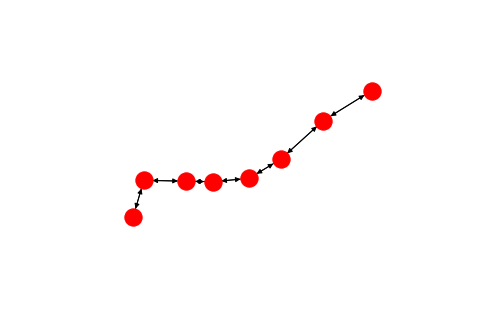

In [4]:
FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

path = [[node_1, node_2], 
        [node_2, node_1], 
        [node_2, node_3], 
        [node_3, node_2], 
        [node_3, node_4], 
        [node_4, node_3],
        [node_4, node_5], 
        [node_5, node_4], 
        [node_5, node_6], 
        [node_6, node_5], 
        [node_6, node_7], 
        [node_7, node_6],
        [node_7, node_8], 
        [node_8, node_7]] 

dur = {(node_1, node_2): 2, 
        (node_2, node_1): 2, 
        (node_2, node_3): 2, 
        (node_3, node_2): 2, 
        (node_3, node_4): 2, 
        (node_4, node_3): 2,
        (node_4, node_5): 2, 
        (node_5, node_4): 2, 
        (node_5, node_6): 2, 
        (node_6, node_5): 2, 
        (node_6, node_7): 2, 
        (node_7, node_6): 2,
        (node_7, node_8): 3, 
        (node_8, node_7): 3}

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, duration = dur[(edge[0], edge[1])])

nx.draw(FG, positions)
plt.show()

### Create moving parts

In [5]:
def generate_passenger(origin, destination, environment):
    """ Generate a passenger """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
    
    # Travel direction
    route = nx.dijkstra_path(environment.FG, origin, destination, weight = 'duration')
    
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route})

In [6]:
def generate_metro(origin, destination, environment):
    """ Generate a metro """
    Metro = type('Metro', (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, 
                           core.Routeable, core.Mover), {})

    # Name of the object
    name = "Metro"
    
    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
    
    # Travel direction
    route = nx.dijkstra_path(environment.FG, origin, destination, weight = 'duration')
    
    # Maximum passengers
    capacity = 50
    
    return Metro(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry})

### Spawn the metro trains

In [7]:
def metroNZ(env):
    yield env.timeout(5.5 * 60 * 60)
    while True:
        metro = generate_metro("Noord", "Zuid", env)
        env.metros.append(metro)
        env.process(metro.move())
        
        # One metro every X minutes
        yield env.timeout(6 * 60)
        
def metroZN(env):
    yield env.timeout(5.585 * 60 * 60)
    while True:
        metro = generate_metro("Zuid", "Noord", env)
        env.metros.append(metro)
        env.process(metro.move())
        
        # One metro every X minutes
        yield env.timeout(6 * 60)

In [8]:
def passengers(env):
    yield env.timeout(5.5 * 60 * 60)
    while True:
        origin, destination = random.sample(env.FG.nodes, 2)
        
        passenger = generate_passenger(origin, destination, env)
        FG.nodes[origin]["object_type"].units.append(passenger)
        
        passenger.log_entry("Waiting for metro start", env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
        env.passengers.append(passenger)
        
        # Random arrivals of passengers with mean interarrival time of 30 seconds
        yield env.timeout(random.random() * 60)

### Run simulation

In [9]:
# Simulation start time
simulation_start = datetime.datetime(2019, 1, 1)

# Make simulation environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.FG = FG

# For loggin
env.metros = []
env.passengers = []

# Start the simulation
env.process(metroZN(env))
env.process(metroNZ(env))
env.process(passengers(env))
env.run(until = env.now + 1 * 24 * 60 * 60)

### Check results

In [10]:
env.passengers[0].route

['Noord', 'Noorderpark']

In [11]:
env.passengers[0].log

{'Message': ['Waiting for metro start',
  'Waiting for metro stop',
  'In metro start',
  'In metro stop'],
 'Timestamp': [datetime.datetime(2019, 1, 1, 5, 30),
  datetime.datetime(2019, 1, 1, 5, 36),
  datetime.datetime(2019, 1, 1, 5, 36),
  datetime.datetime(2019, 1, 1, 5, 38)],
 'Value': [0, 0, 0, 0],
 'Geometry': [<shapely.geometry.point.Point at 0x10f2a19b0>,
  <shapely.geometry.point.Point at 0x10f2a19e8>]}

In [13]:
# What routes did people (i = person) take that took this metro
for i in env.metros[1].units:
    print(i.route)

['Europaplein', 'DePijp']
['Vijzelgracht', 'Rokin', 'CentraalStation', 'Noorderpark', 'Noord']
['Noorderpark', 'Noord']


In [14]:
env.metros[0].log

{'Message': ['Driving from Noord to Noorderpark start',
  'Driving from Noord to Noorderpark stop',
  'Unloading start',
  'Unloading stop',
  'Driving from Noorderpark to CentraalStation start',
  'Driving from Noorderpark to CentraalStation stop',
  'Unloading start',
  'Unloading stop',
  'Loading start',
  'Loading stop',
  'Driving from CentraalStation to Rokin start',
  'Driving from CentraalStation to Rokin stop',
  'Unloading start',
  'Unloading stop',
  'Loading start',
  'Loading stop',
  'Driving from Rokin to Vijzelgracht start',
  'Driving from Rokin to Vijzelgracht stop',
  'Unloading start',
  'Unloading stop',
  'Loading start',
  'Loading stop',
  'Driving from Vijzelgracht to DePijp start',
  'Driving from Vijzelgracht to DePijp stop',
  'Unloading start',
  'Unloading stop',
  'Loading start',
  'Loading stop',
  'Driving from DePijp to Europaplein start',
  'Driving from DePijp to Europaplein stop',
  'Unloading start',
  'Unloading stop',
  'Driving from Europaple

In [15]:
env.passengers[1].__dict__

{'env': <simpy.core.Environment at 0x10f2a4e80>,
 'log': {'Message': ['Waiting for metro start',
   'Waiting for metro stop',
   'In metro start',
   'In metro stop'],
  'Timestamp': [datetime.datetime(2019, 1, 1, 5, 30, 49, 516377),
   datetime.datetime(2019, 1, 1, 5, 35, 6),
   datetime.datetime(2019, 1, 1, 5, 35, 6),
   datetime.datetime(2019, 1, 1, 5, 40, 21)],
  'Value': [0, 0, 0, 0],
  'Geometry': [<shapely.geometry.point.Point at 0x10f2a1c18>,
   <shapely.geometry.point.Point at 0x10f2a1ba8>]},
 'route': ['Zuid', 'Europaplein', 'DePijp'],
 'complete_path': None,
 'name': 'Passenger',
 'id': '9ce327d0-6be5-11e9-9ecf-7831c1d08f6a'}

In [19]:
pd.DataFrame.from_dict(env.metros[1].log)

,Message,Timestamp,Value,Geometry
0,Loading start,2019-01-01 05:35:06,0,POINT (52.33908015 4.87509853)
1,Loading stop,2019-01-01 05:35:06,0,POINT (52.33908015 4.87509853)
2,Driving from Zuid to Europaplein start,2019-01-01 05:35:06,0,POINT (52.33908015 4.87509853)
3,Driving from Zuid to Europaplein stop,2019-01-01 05:38:06,0,POINT (52.34185482 4.8913843)
4,Unloading start,2019-01-01 05:38:06,0,POINT (52.34185482 4.8913843)
5,Unloading stop,2019-01-01 05:38:06,0,POINT (52.34185482 4.8913843)
6,Loading start,2019-01-01 05:38:21,0,POINT (52.34185482 4.8913843)
7,Loading stop,2019-01-01 05:38:21,0,POINT (52.34185482 4.8913843)
8,Driving from Europaplein to DePijp start,2019-01-01 05:38:21,0,POINT (52.34185482 4.8913843)
9,Driving from Europaplein to DePijp stop,2019-01-01 05:40:21,0,POINT (52.35296212 4.89101069)
